## Import Libraries

In [42]:
import pm4py
import pandas as pd
import os
import plotly.express as px
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.visualization.petri_net import visualizer as pn_vis
import matplotlib.pyplot as plt

## Data Preprocessing

In [43]:
#Define directories
current_dir = os.getcwd()
project_dir = os.path.dirname(current_dir)
database_dir = os.path.join(project_dir, 'data.partc.cis7026.20285864')

In [44]:
#Event log data
event_log = os.path.join(database_dir, 'insurance_claims_event_log.csv')

In [45]:
#read the event log csv file
event_log = pd.read_csv(event_log)
event_log.head()

,case_id,activity_name,timestamp,claimant_name,agent_name,adjuster_name,claim_amount,claimant_age,type_of_policy,car_make,car_model,car_year,type_of_accident,user_type
0,a626bc58-a7b2-4eff-aca9-2a622cd0c492,First Notification of Loss (FNOL),2020-09-24 14:08:42.423530,Karen Lopez,Thomas Cantu,Ian Garcia,1914.96,75,Collision,Honda,Civic,2012,Rollover,RPA
1,a626bc58-a7b2-4eff-aca9-2a622cd0c492,Assign Claim,2020-10-13 03:51:28.627923,Karen Lopez,Thomas Cantu,Ian Garcia,1914.96,75,Collision,Honda,Civic,2012,Rollover,RPA
2,a626bc58-a7b2-4eff-aca9-2a622cd0c492,Claim Decision,2020-10-14 22:30:14.948970,Karen Lopez,Thomas Cantu,Ian Garcia,1914.96,75,Collision,Honda,Civic,2012,Rollover,RPA
3,a626bc58-a7b2-4eff-aca9-2a622cd0c492,Set Reserve,2020-10-24 11:49:39.053890,Karen Lopez,Thomas Cantu,Ian Garcia,1914.96,75,Collision,Honda,Civic,2012,Rollover,RPA
4,a626bc58-a7b2-4eff-aca9-2a622cd0c492,Payment Sent,2020-10-27 05:46:04.378718,Karen Lopez,Thomas Cantu,Ian Garcia,1914.96,75,Collision,Honda,Civic,2012,Rollover,RPA


In [46]:
#Sort the event log by case id and timestamp descending
event_log = event_log.sort_values(['case_id', 'timestamp'])
event_log.head()

,case_id,activity_name,timestamp,claimant_name,agent_name,adjuster_name,claim_amount,claimant_age,type_of_policy,car_make,car_model,car_year,type_of_accident,user_type
75954,000112d5-9d04-450f-820f-3edfc0626cf9,First Notification of Loss (FNOL),2022-04-19 01:47:54.857481,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human
75955,000112d5-9d04-450f-820f-3edfc0626cf9,Assign Claim,2022-05-01 18:11:26.417687,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human
75956,000112d5-9d04-450f-820f-3edfc0626cf9,Claim Decision,2022-05-03 07:01:46.479057,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human
75957,000112d5-9d04-450f-820f-3edfc0626cf9,Set Reserve,2022-05-08 09:26:47.468433,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human
75958,000112d5-9d04-450f-820f-3edfc0626cf9,Payment Sent,2022-05-15 16:12:46.119925,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human


In [47]:
#Column names
event_log.columns

Index(['case_id', 'activity_name', 'timestamp', 'claimant_name', 'agent_name',
       'adjuster_name', 'claim_amount', 'claimant_age', 'type_of_policy',
       'car_make', 'car_model', 'car_year', 'type_of_accident', 'user_type'],
      dtype='object')

In [48]:
#number of Unique adjuster_name
event_log['type_of_accident'].nunique()

4

In [49]:
#Data Type of timestamp
event_log['timestamp'] = pd.to_datetime(event_log['timestamp'])

In [50]:
#No of Events
print('No of Events:', len(event_log))

#No of Unique Cases
print('No of Unique Cases:', len(event_log['case_id'].unique()))

#No of Unique Activities
print('No of Unique Activities:', len(event_log['activity_name'].unique()))

No of Events: 180000
No of Unique Cases: 30000
No of Unique Activities: 6


In [51]:
event_log_process = pm4py.format_dataframe(event_log, case_id='case_id', activity_key='activity_name', timestamp_key='timestamp')

In [52]:
#Start Activties
start_activities = pm4py.get_start_activities(event_log_process)

#End Activties
end_activities = pm4py.get_end_activities(event_log_process)

#Print Start and End Activities
print('Start Activities:', start_activities)
print('End Activities:', end_activities)

Start Activities: {'First Notification of Loss (FNOL)': 30000}
End Activities: {'Close Claim': 29820, 'Payment Sent': 177, 'Set Reserve': 3}


In [53]:
#Define the standard process flow
standard_process_flow = ['First Notification of Loss (FNOL)', 'Assign Claim', 'Claim Decision', 'Set Reserve', 'Payment Sent', 'Close Claim']

In [54]:
#No of casees which has follow the standard process flow
no_of_cases = 0
for case_id, group in event_log.groupby('case_id'):
    activities = group['activity_name'].tolist()
    if activities == standard_process_flow:
        no_of_cases += 1
no_of_cases

#Print the number of cases that follow the standard process flow
print('Number of cases that follow the standard process flow:', no_of_cases)

Number of cases that follow the standard process flow: 29265


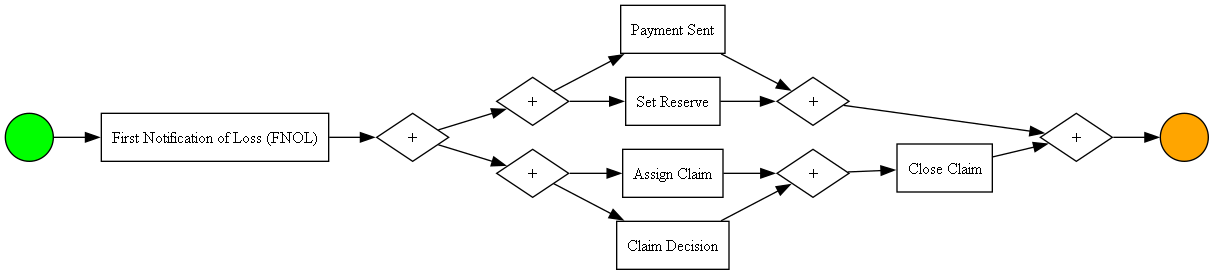

In [55]:
#Process Model
process_model = pm4py.discover_bpmn_inductive(event_log_process)
pm4py.view_bpmn(process_model)

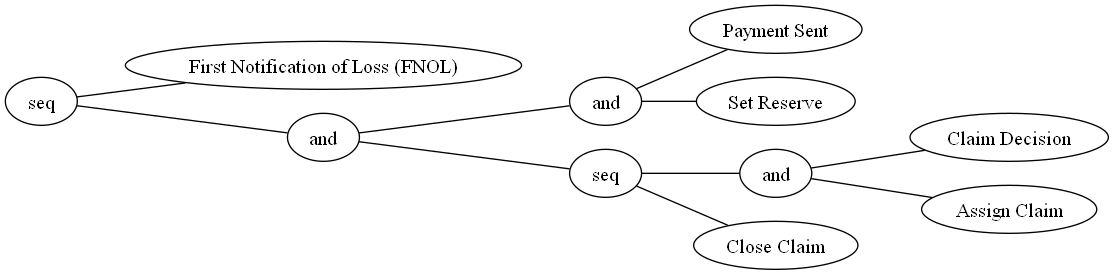

In [56]:
#Process Tree
process_tree = pm4py.discover_process_tree_inductive(event_log_process)
pm4py.view_process_tree(process_tree)

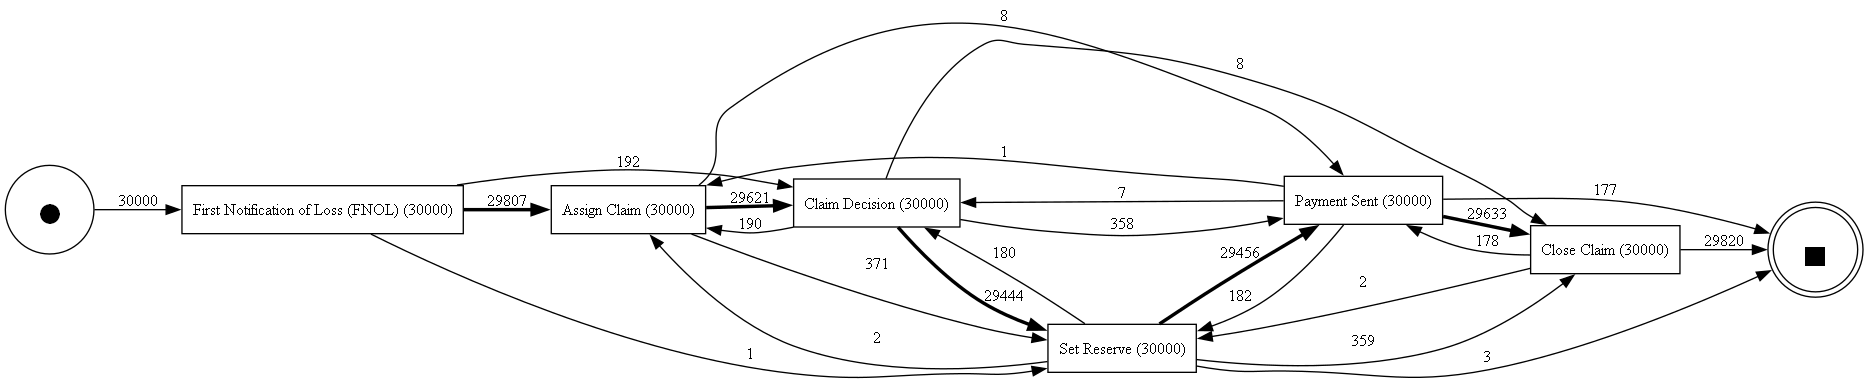

In [57]:
#Discover directly follows graph
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log_process)
pm4py.view_dfg(dfg, start_activities, end_activities)

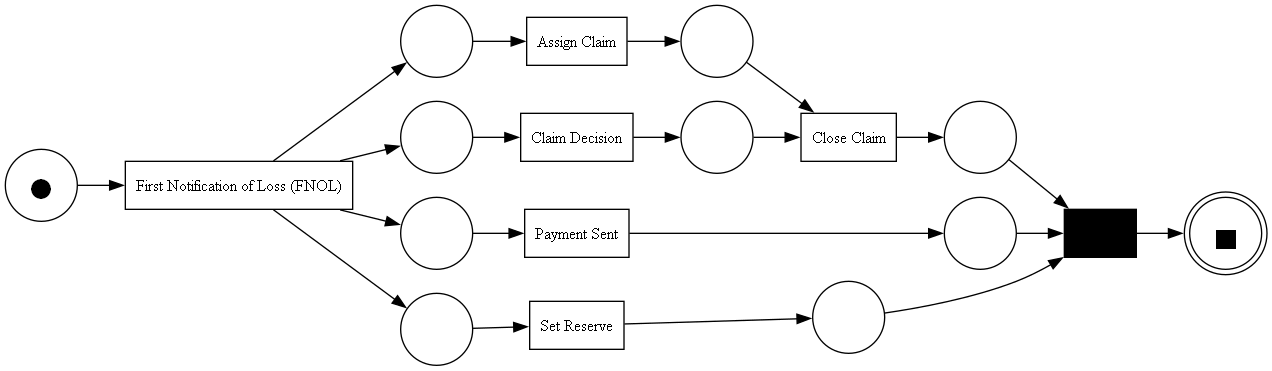

In [58]:
#Discovery of Petri Net
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log_process)
pm4py.view_petri_net(net, initial_marking, final_marking)

In [59]:
#Group the event log by case id and get the list of activities for each case
grouped_event_log = event_log.groupby('case_id')['activity_name'].apply(list).reset_index()
grouped_event_log.head()


,case_id,activity_name
0,000112d5-9d04-450f-820f-3edfc0626cf9,"[First Notification of Loss (FNOL), Assign Cla..."
1,0001c62c-696c-4251-a604-8d319fc73fac,"[First Notification of Loss (FNOL), Assign Cla..."
2,00048c02-65b5-423b-bf38-139a099a5624,"[First Notification of Loss (FNOL), Assign Cla..."
3,0005b367-5a31-4bcd-82f3-05103f43b462,"[First Notification of Loss (FNOL), Assign Cla..."
4,000694f5-9a75-4885-ab77-7842d78188ae,"[First Notification of Loss (FNOL), Assign Cla..."


In [60]:
#Lambda Function to check if the process flow is correct for each case with the standard process flow
grouped_event_log['correct_process_flow'] = grouped_event_log['activity_name'].apply(lambda x: x == standard_process_flow)
grouped_event_log.head()

#Rename the column correct_process_flow to fitness
grouped_event_log.rename(columns={'correct_process_flow': 'fitness'}, inplace=True)

#Calculate the fitness of the process flow
fitness = grouped_event_log['fitness'].sum() / len(grouped_event_log)

#Print the fitness of the process flow
print('Fitness of the process flow:', fitness)

Fitness of the process flow: 0.9755


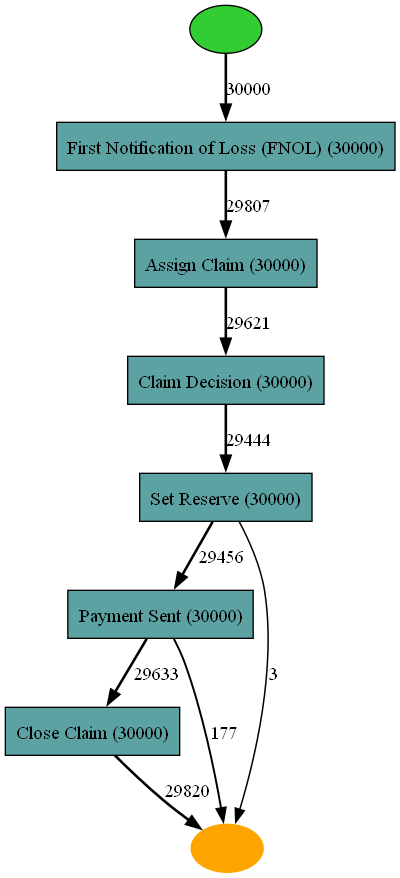

In [61]:
#Discovery of Heuristic Net
heu_net = pm4py.discover_heuristics_net(event_log_process)
pm4py.view_heuristics_net(heu_net)

#### Average Duration for Each Activity for Checking Bottlenecks

In [62]:
#Get only case_id, activity_name and timestamp columns
event_log_1 = event_log[['case_id', 'activity_name', 'timestamp']]
event_log_1.head()

,case_id,activity_name,timestamp
75954,000112d5-9d04-450f-820f-3edfc0626cf9,First Notification of Loss (FNOL),2022-04-19 01:47:54.857481+00:00
75955,000112d5-9d04-450f-820f-3edfc0626cf9,Assign Claim,2022-05-01 18:11:26.417687+00:00
75956,000112d5-9d04-450f-820f-3edfc0626cf9,Claim Decision,2022-05-03 07:01:46.479057+00:00
75957,000112d5-9d04-450f-820f-3edfc0626cf9,Set Reserve,2022-05-08 09:26:47.468433+00:00
75958,000112d5-9d04-450f-820f-3edfc0626cf9,Payment Sent,2022-05-15 16:12:46.119925+00:00


In [63]:
#Get a New Column for the Duration of each Activity as a timedelta & Set the duration of the first activity in each case to 0
event_log_1['duration'] = event_log_1.groupby('case_id')['timestamp'].diff().fillna(pd.Timedelta(seconds=0))
event_log_1

C:\Users\Rameez\AppData\Local\Temp\ipykernel_11944\3285484739.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,case_id,activity_name,timestamp,duration
75954,000112d5-9d04-450f-820f-3edfc0626cf9,First Notification of Loss (FNOL),2022-04-19 01:47:54.857481+00:00,0 days 00:00:00
75955,000112d5-9d04-450f-820f-3edfc0626cf9,Assign Claim,2022-05-01 18:11:26.417687+00:00,12 days 16:23:31.560206
75956,000112d5-9d04-450f-820f-3edfc0626cf9,Claim Decision,2022-05-03 07:01:46.479057+00:00,1 days 12:50:20.061370
75957,000112d5-9d04-450f-820f-3edfc0626cf9,Set Reserve,2022-05-08 09:26:47.468433+00:00,5 days 02:25:00.989376
75958,000112d5-9d04-450f-820f-3edfc0626cf9,Payment Sent,2022-05-15 16:12:46.119925+00:00,7 days 06:45:58.651492
...,...,...,...,...
178183,fffb4dea-5d95-4dcc-9a99-282595614167,Assign Claim,2020-10-10 03:37:52.454864+00:00,18 days 08:56:19.316577
178184,fffb4dea-5d95-4dcc-9a99-282595614167,Claim Decision,2020-10-16 05:55:58.595998+00:00,6 days 02:18:06.141134
178185,fffb4dea-5d95-4dcc-9a99-282595614167,Set Reserve,2020-10-22 00:24:25.685952+00:00,5 days 18:28:27.089954
178186,fffb4dea-5d95-4dcc-9a99-282595614167,Payment Sent,2020-10-26 01:28:37.183466+00:00,4 days 01:04:11.497514


In [64]:
#Get the average duration of each activity
avg_duration = event_log_1.groupby('activity_name')['duration'].mean()
avg_duration

activity_name
Assign Claim                        14 days 22:01:57.090470726
Claim Decision                       5 days 01:54:00.345991473
Close Claim                          5 days 00:14:04.053826297
First Notification of Loss (FNOL)              0 days 00:00:00
Payment Sent                         4 days 23:59:19.669557470
Set Reserve                          5 days 00:12:40.208624995
Name: duration, dtype: timedelta64[ns]

In [65]:
#Duration in days
avg_duration = avg_duration.dt.total_seconds() / 86400 #86400 seconds in a day
avg_duration

activity_name
Assign Claim                         14.918022
Claim Decision                        5.079171
Close Claim                           5.009769
First Notification of Loss (FNOL)     0.000000
Payment Sent                          4.999533
Set Reserve                           5.008799
Name: duration, dtype: float64

In [66]:
#Plot the average duration of each activity in dark mode
fig = px.bar(avg_duration, x=avg_duration.index, y='duration')

fig.update_xaxes(title_text='Activity Name')
fig.update_yaxes(title_text='Average Duration (days)')

#Set the overall average duration of all activities
avg_duration_all = event_log_1['duration'].mean().total_seconds() / 86400
fig.add_hline(y=avg_duration_all, line_dash='dot', annotation_text='Overall Average Duration', annotation_position='top right')

fig.update_layout(template='plotly_dark')
fig.show()

In [67]:
event_log_process.head()

,case_id,activity_name,timestamp,claimant_name,agent_name,adjuster_name,claim_amount,claimant_age,type_of_policy,car_make,car_model,car_year,type_of_accident,user_type,case:concept:name,concept:name,time:timestamp,@@index,@@case_index,start_timestamp
0,000112d5-9d04-450f-820f-3edfc0626cf9,First Notification of Loss (FNOL),2022-04-19 01:47:54.857481+00:00,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human,000112d5-9d04-450f-820f-3edfc0626cf9,First Notification of Loss (FNOL),2022-04-19 01:47:54.857481+00:00,0,0,2022-04-19 01:47:54.857481+00:00
1,000112d5-9d04-450f-820f-3edfc0626cf9,Assign Claim,2022-05-01 18:11:26.417687+00:00,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human,000112d5-9d04-450f-820f-3edfc0626cf9,Assign Claim,2022-05-01 18:11:26.417687+00:00,1,0,2022-05-01 18:11:26.417687+00:00
2,000112d5-9d04-450f-820f-3edfc0626cf9,Claim Decision,2022-05-03 07:01:46.479057+00:00,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human,000112d5-9d04-450f-820f-3edfc0626cf9,Claim Decision,2022-05-03 07:01:46.479057+00:00,2,0,2022-05-03 07:01:46.479057+00:00
3,000112d5-9d04-450f-820f-3edfc0626cf9,Set Reserve,2022-05-08 09:26:47.468433+00:00,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human,000112d5-9d04-450f-820f-3edfc0626cf9,Set Reserve,2022-05-08 09:26:47.468433+00:00,3,0,2022-05-08 09:26:47.468433+00:00
4,000112d5-9d04-450f-820f-3edfc0626cf9,Payment Sent,2022-05-15 16:12:46.119925+00:00,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human,000112d5-9d04-450f-820f-3edfc0626cf9,Payment Sent,2022-05-15 16:12:46.119925+00:00,4,0,2022-05-15 16:12:46.119925+00:00


In [68]:
average_claim_amount = event_log.groupby('claimant_name')['claim_amount'].mean()
average_claim_amount

claimant_name
Aaron Anderson    7725.40
Aaron Bates       8569.25
Aaron Becker      3472.43
Aaron Brock       6562.32
Aaron Brown       4275.97
                   ...   
Zoe Fischer       1955.40
Zoe Hill          5189.98
Zoe Hudson        7216.39
Zoe James         4075.90
Zoe Shannon       3288.92
Name: claim_amount, Length: 25778, dtype: float64

#### Checking for Process Frauds in Higher Claims

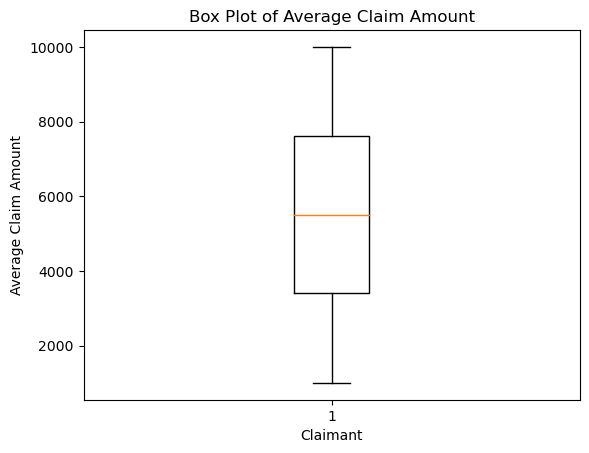

In [69]:
#Box plot the average claim amount
plt.boxplot(average_claim_amount.values)

# Set the title and labels
plt.title('Box Plot of Average Claim Amount')
plt.xlabel('Claimant')
plt.ylabel('Average Claim Amount')

#Show the plot
plt.show()

In [70]:
#Get the higher leveel
Q3 = average_claim_amount.quantile(0.75)
Q1 = average_claim_amount.quantile(0.25)

#Get the claimants with average claim amount greater than Q3
higher_claimants = average_claim_amount[average_claim_amount > Q3]
higher_claimants

claimant_name
Aaron Anderson     7725.40
Aaron Bates        8569.25
Aaron Calderon     9912.82
Aaron Gonzalez     9271.00
Aaron Hardy        8503.70
                    ...   
Zachary Meyer      9278.13
Zachary Nelson     8325.92
Zachary Patrick    8943.11
Zachary Poole      7942.31
Zachary Rivera     8551.03
Name: claim_amount, Length: 6445, dtype: float64

In [71]:
#Get the events of the higher claimants
higher_claimants_events = event_log[event_log['claimant_name'].isin(higher_claimants.index)]
higher_claimants_events

,case_id,activity_name,timestamp,claimant_name,agent_name,adjuster_name,claim_amount,claimant_age,type_of_policy,car_make,car_model,car_year,type_of_accident,user_type,case:concept:name,concept:name,time:timestamp
75954,000112d5-9d04-450f-820f-3edfc0626cf9,First Notification of Loss (FNOL),2022-04-19 01:47:54.857481+00:00,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human,000112d5-9d04-450f-820f-3edfc0626cf9,First Notification of Loss (FNOL),2022-04-19 01:47:54.857481+00:00
75955,000112d5-9d04-450f-820f-3edfc0626cf9,Assign Claim,2022-05-01 18:11:26.417687+00:00,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human,000112d5-9d04-450f-820f-3edfc0626cf9,Assign Claim,2022-05-01 18:11:26.417687+00:00
75956,000112d5-9d04-450f-820f-3edfc0626cf9,Claim Decision,2022-05-03 07:01:46.479057+00:00,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human,000112d5-9d04-450f-820f-3edfc0626cf9,Claim Decision,2022-05-03 07:01:46.479057+00:00
75957,000112d5-9d04-450f-820f-3edfc0626cf9,Set Reserve,2022-05-08 09:26:47.468433+00:00,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human,000112d5-9d04-450f-820f-3edfc0626cf9,Set Reserve,2022-05-08 09:26:47.468433+00:00
75958,000112d5-9d04-450f-820f-3edfc0626cf9,Payment Sent,2022-05-15 16:12:46.119925+00:00,Kimberly Collins,Hannah Lopez,Joy Simpson,9266.19,60,Comprehensive,Hyundai,Elantra,2021,Head-on,Human,000112d5-9d04-450f-820f-3edfc0626cf9,Payment Sent,2022-05-15 16:12:46.119925+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45649,fff3858f-47d9-40b8-9847-b98a4436dc2a,Assign Claim,2021-01-29 15:24:42.905833+00:00,Michael Ochoa,Brittney Martinez,James Berry,9941.74,36,Liability,Toyota,Camry,2016,Head-on,RPA,fff3858f-47d9-40b8-9847-b98a4436dc2a,Assign Claim,2021-01-29 15:24:42.905833+00:00
45650,fff3858f-47d9-40b8-9847-b98a4436dc2a,Claim Decision,2021-02-03 12:20:08.348152+00:00,Michael Ochoa,Brittney Martinez,James Berry,9941.74,36,Liability,Toyota,Camry,2016,Head-on,RPA,fff3858f-47d9-40b8-9847-b98a4436dc2a,Claim Decision,2021-02-03 12:20:08.348152+00:00
45651,fff3858f-47d9-40b8-9847-b98a4436dc2a,Set Reserve,2021-02-08 13:14:45.356871+00:00,Michael Ochoa,Brittney Martinez,James Berry,9941.74,36,Liability,Toyota,Camry,2016,Head-on,RPA,fff3858f-47d9-40b8-9847-b98a4436dc2a,Set Reserve,2021-02-08 13:14:45.356871+00:00
45652,fff3858f-47d9-40b8-9847-b98a4436dc2a,Payment Sent,2021-02-18 03:22:18.311661+00:00,Michael Ochoa,Brittney Martinez,James Berry,9941.74,36,Liability,Toyota,Camry,2016,Head-on,RPA,fff3858f-47d9-40b8-9847-b98a4436dc2a,Payment Sent,2021-02-18 03:22:18.311661+00:00


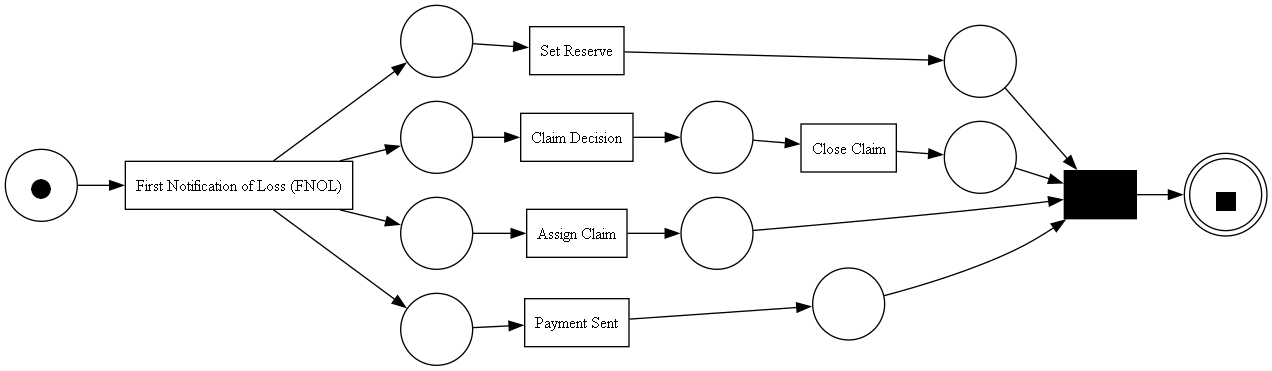

In [72]:
#Discovery of Petri Net
higher_net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(higher_claimants_events)
pm4py.view_petri_net(higher_net, initial_marking, final_marking)

c:\Users\Rameez\anaconda3\lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:73: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



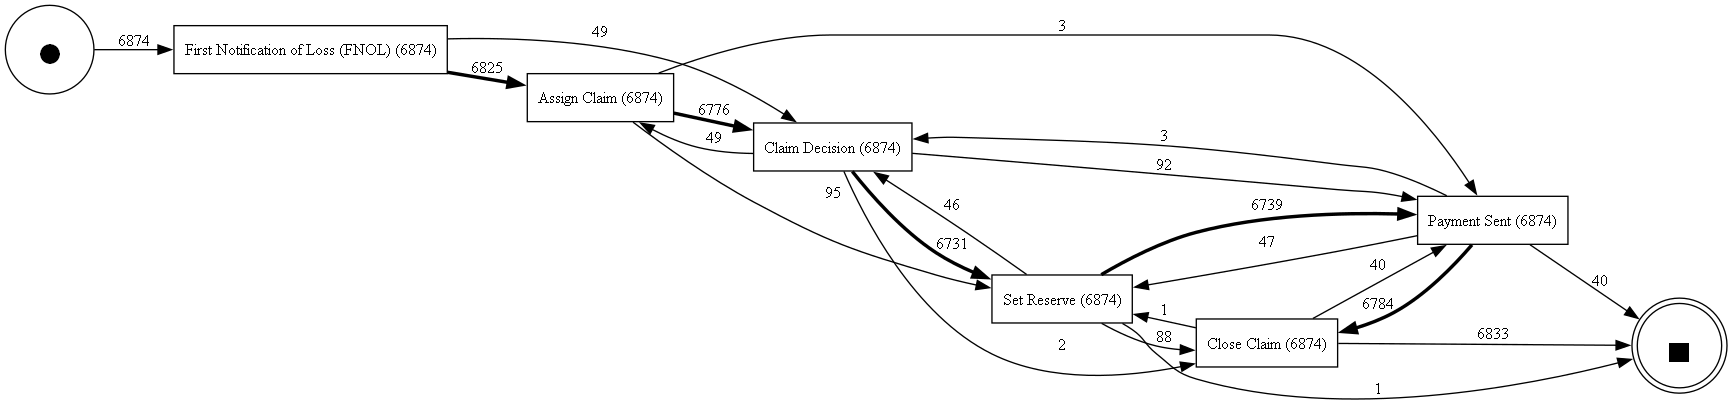

In [73]:
#Discover directly follows graph for higher claimants
dfg_higher, start_activities, end_activities = pm4py.discover_dfg(higher_claimants_events)
pm4py.view_dfg(dfg_higher, start_activities, end_activities)

In [74]:
#No of cases which has not followed the standard process flow from the higher claimants
no_of_cases = 0
for case_id, group in higher_claimants_events.groupby('case_id'):
    activities = group['activity_name'].tolist()
    if activities == standard_process_flow:
        no_of_cases += 1
no_of_cases

#Print No of cases which has not followed the standard process flow from the higher claimants
print('No of cases which has not followed the standard process flow from the higher claimants:', no_of_cases)

No of cases which has not followed the standard process flow from the higher claimants: 6690


In [75]:
#Group the event log by case id and get the list of activities for each case of the higher claimants
grouped_higher_claimants_events = higher_claimants_events.groupby('case_id')['activity_name'].apply(list).reset_index()
grouped_higher_claimants_events.head()

,case_id,activity_name
0,000112d5-9d04-450f-820f-3edfc0626cf9,"[First Notification of Loss (FNOL), Assign Cla..."
1,0005b367-5a31-4bcd-82f3-05103f43b462,"[First Notification of Loss (FNOL), Assign Cla..."
2,003082d8-6a70-4fce-9ee3-69cbdfb837dc,"[First Notification of Loss (FNOL), Assign Cla..."
3,00614b95-6c9d-4012-9d5b-1c7bb68edaf0,"[First Notification of Loss (FNOL), Assign Cla..."
4,006efcfd-eec1-4366-b11a-5ed25dcf5abd,"[First Notification of Loss (FNOL), Assign Cla..."


In [76]:
#Lambda Function to check if the process flow is correct for each case with the standard process flow for the higher claimants
grouped_higher_claimants_events['correct_process_flow'] = grouped_higher_claimants_events['activity_name'].apply(lambda x: x == standard_process_flow)
grouped_higher_claimants_events.head()

#Rename the column correct_process_flow to fitness
grouped_higher_claimants_events.rename(columns={'correct_process_flow': 'fitness'}, inplace=True)

#Calculate the fitness of the process flow for the higher claimants
fitness = grouped_higher_claimants_events['fitness'].sum() / len(grouped_higher_claimants_events)

#Print the fitness of the process flow for the higher claimants
print('Fitness of the process flow for the higher claimants:', fitness)

Fitness of the process flow for the higher claimants: 0.9732324701774804
